In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.fftpack import dct
from scipy.fftpack import idct

In [2]:
# 원전 내부의 충돌체 정보를 네개의 센서 정보만으로 특정해내기
# 데이터 출처 : https://dacon.io/competitions/official/235614/overview/description/
train_features = pd.read_csv('D:/Data/KAERI_dataset/train_features.csv')
train_target = pd.read_csv('D:/Data/KAERI_dataset/train_target.csv')

In [3]:
train_features.shape, train_target.shape

((1050000, 6), (2800, 5))

In [4]:
train_features.head()

,id,Time,S1,S2,S3,S4
0,0,0.000000,0.0,0.0,0.0,0.0
1,0,0.000004,0.0,0.0,0.0,0.0
2,0,0.000008,0.0,0.0,0.0,0.0
3,0,0.000012,0.0,0.0,0.0,0.0
4,0,0.000016,0.0,0.0,0.0,0.0


In [5]:
# scipy에서 Discrete Cosine Transform을 사용, 원하는 만큼만 잘라낼 수 있게 함수 설정
def fourier_trsf(data,sensor,idx=10,cutoff=65):
	cond_id = data['id']==idx
	wave = data.loc[cond_id,sensor].values
	time = data.loc[cond_id,'Time']
	fft_wave = dct(wave, type=2,n=time.shape[0],norm='ortho')
	freq = np.fft.fftfreq(wave.size,d=0.000004)
	cw = np.copy(fft_wave)
	cw[cutoff:]=0
	fft_wave_2 = np.real(idct(cw,norm='ortho'))
	
	return {"cw":cw[:cutoff],"fft":fft_wave, "freq":freq, "fft_cutoff":fft_wave_2, "time":time, "wave":wave}

In [6]:
# id 하나만 찍어서 확인, 총 375개
train_features[train_features['id']==0]

,id,Time,S1,S2,S3,S4
0,0,0.000000,0.00,0.00,0.00,0.000
1,0,0.000004,0.00,0.00,0.00,0.000
2,0,0.000008,0.00,0.00,0.00,0.000
3,0,0.000012,0.00,0.00,0.00,0.000
4,0,0.000016,0.00,0.00,0.00,0.000
...,...,...,...,...,...,...
370,0,0.001480,-64168.90,-64168.90,52279.59,106792.600
371,0,0.001484,-64236.79,-64236.79,16518.64,58248.420
372,0,0.001488,-63755.95,-63755.95,-25270.30,3015.649
373,0,0.001492,-63020.44,-63020.44,-65904.66,-49795.140


In [7]:
# id가 총 몇개인지 확인, 2800개
len( train_features['id'].unique() )

2800

In [8]:
# id마다 가지고 있는 행 개수가 다 같을까?
# 375개로 나누어 보니 딱 떨어지긴 한다
train_features.shape[0]/375

2800.0

In [9]:
# time은 id마다 다를까? 아니면 동일할까?
# time의 종류도 딱 375개 인걸로 봐선 동일한 시간 간격으로 기록된 것들이다
len(train_features['Time'].unique() )

375

In [10]:
# id=10을 예시로 삼아 살펴보자
train_features[train_features['id']==10]

,id,Time,S1,S2,S3,S4
3750,10,0.000000,0.00,0.000000,0.0,0.0
3751,10,0.000004,0.00,0.000000,0.0,0.0
3752,10,0.000008,0.00,0.000012,0.0,0.0
3753,10,0.000012,0.00,0.025942,0.0,0.0
3754,10,0.000016,0.00,-4.869326,0.0,0.0
...,...,...,...,...,...,...
4120,10,0.001480,-153924.80,-20263.540000,-260804.9,184858.2
4121,10,0.001484,-27967.33,9682.087000,-236084.6,296736.4
4122,10,0.001488,92564.70,28692.150000,-207750.6,409014.5
4123,10,0.001492,188116.90,37090.780000,-179889.7,496129.8


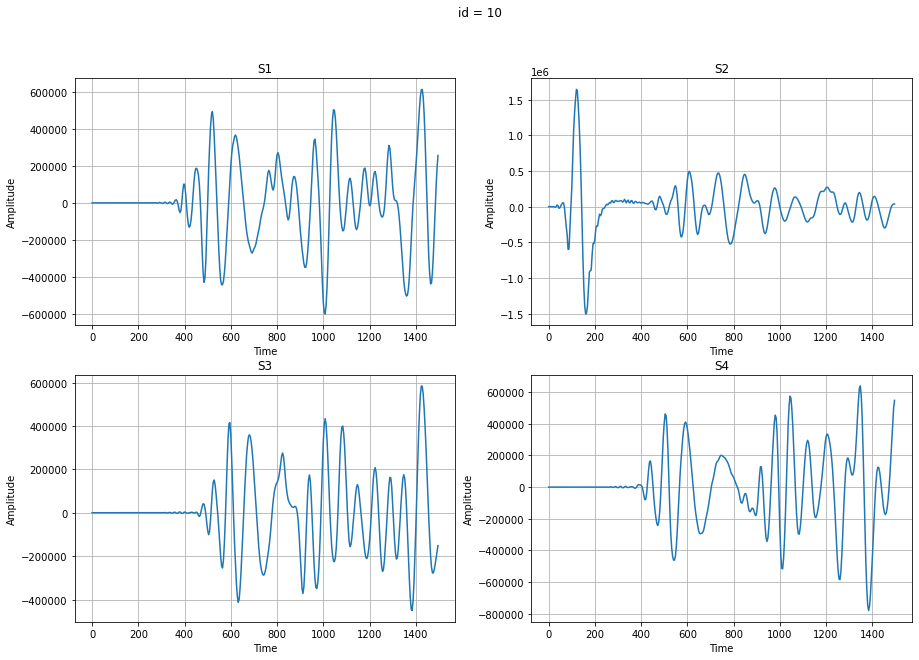

In [11]:
# 이걸 그대로, 시간에 따라 찍어보면....
# 이런 파형 그래프가 된다. 이런게 2800개씩 있다!
# 이 파형 그래프를 이용해서, 타겟을 예측하면 되는데...
def wave_graph(select_id=0):
    fig = plt.figure(figsize=(15,10))
    gs = fig.add_gridspec(2, 2, hspace=0.2, wspace=0.2)
    ax = gs.subplots()
    fig.suptitle('id = '+str(select_id))

    for r,c,s in [(0,0,'S1'),(0,1,'S2'),(1,0,'S3'),(1,1,'S4')]:
        w0 = fourier_trsf(data=train_features,sensor=s,idx=select_id,cutoff=50)
        ax[r][c].plot(w0['time']*10**6, w0['wave'])
        ax[r][c].set_xlabel('Time')
        ax[r][c].set_ylabel('Amplitude')
        ax[r][c].grid(True)
        ax[r][c].set_title(s)

wave_graph(10)

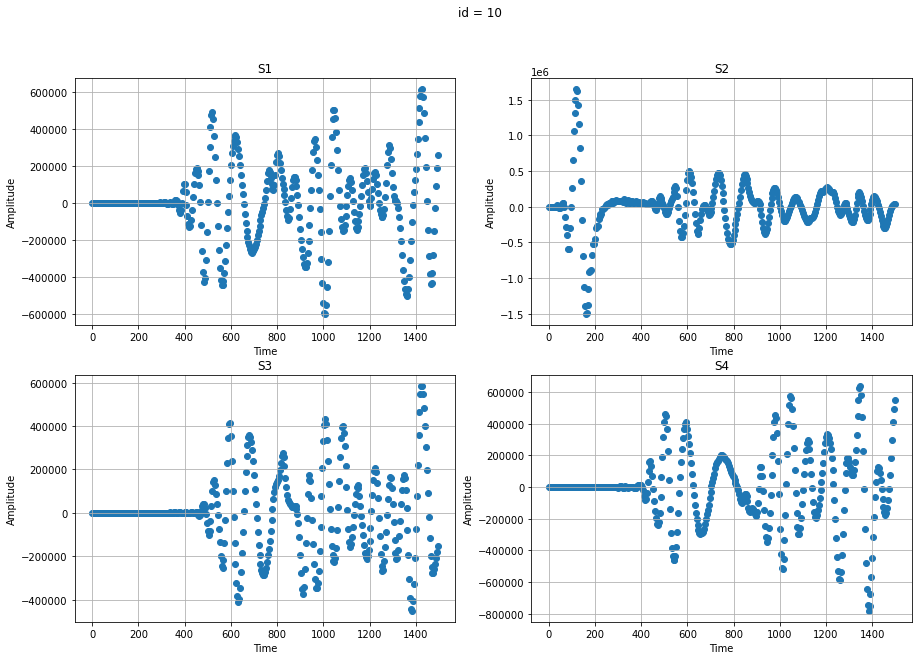

In [12]:
# 여기엔 사실 375개의 점이 있다
# 이걸 그대로 다 사용하면, 375*4 = 1500개의 feature가 있어야 한다
# 너무 많다!
fig = plt.figure(figsize=(15,10))
gs = fig.add_gridspec(2, 2, hspace=0.2, wspace=0.2)
ax = gs.subplots()
fig.suptitle('id = 10')

selcet_id = 10

for r,c,s in [(0,0,'S1'),(0,1,'S2'),(1,0,'S3'),(1,1,'S4')]:
    w0 = fourier_trsf(data=train_features,sensor=s,idx=selcet_id,cutoff=50)
    ax[r][c].scatter(w0['time']*10**6, w0['wave'])
    ax[r][c].set_xlabel('Time')
    ax[r][c].set_ylabel('Amplitude')
    ax[r][c].grid(True)
    ax[r][c].set_title(s)

In [13]:
np.pi

3.141592653589793

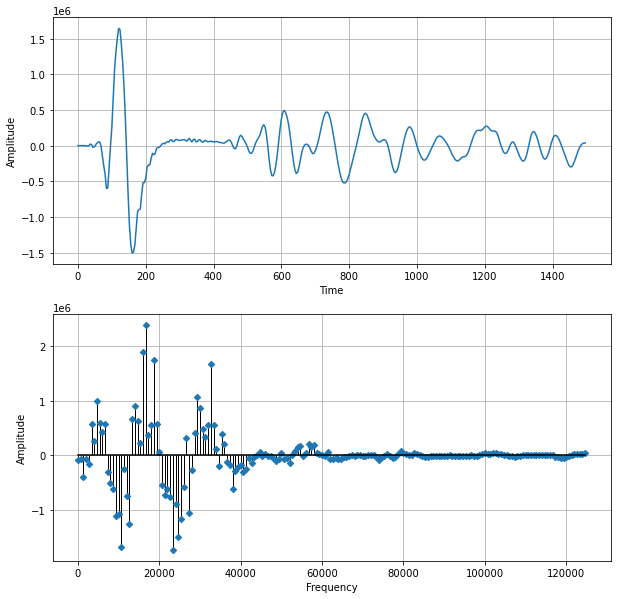

In [14]:
# 이걸 그대로 쓸수는 없으니, 대책이 필요하다
# 그래서 Fourier Transform이란 것을 사용!
# 이걸 이용하면 더 적은 데이터로, 근사적으로 진동을 다룰 수 있다
w0 = fourier_trsf(data=train_features,sensor='S2',idx=10,cutoff=30)

fig = plt.figure(figsize=(10,10))
ax1 = fig.add_subplot(2, 1, 1)
ax2 = fig.add_subplot(2, 1, 2)

ax1.plot(w0['time']*10**6, w0['wave'])
ax1.set_xlabel('Time')
ax1.set_ylabel('Amplitude')
ax1.grid(True)

markerline, stemlines, baseline = ax2.stem(
    w0['freq'][:int(375/2)+1], w0['fft'][:int(375/2)+1],
    linefmt='k-', markerfmt='D ', basefmt='k-'
    ) 
ax2.set_xlabel('Frequency')
ax2.set_ylabel('Amplitude')
ax2.grid(True)

plt.setp(stemlines, linewidth = 1)
plt.setp(markerline, markersize = 4.5)

plt.show()

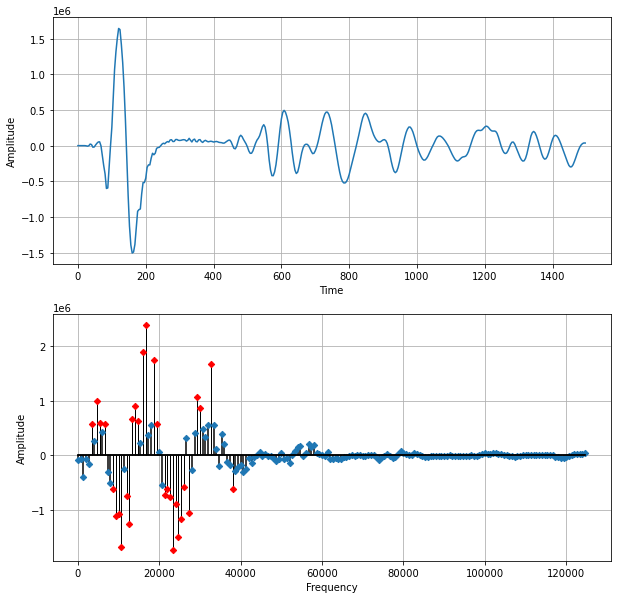

In [15]:
# 구성 성분을 뜯어본 후에, 거기서 가장 세기가 큰 것들 30개만 고르면...
# 대부분 낮은 주파수 쪽에 쏠려 있다
w0 = fourier_trsf(data=train_features,sensor='S2',idx=10,cutoff=30)

fig = plt.figure(figsize=(10,10))
ax1 = fig.add_subplot(2, 1, 1)
ax2 = fig.add_subplot(2, 1, 2)

ax1.plot(w0['time']*10**6, w0['wave'])
ax1.set_xlabel('Time')
ax1.set_ylabel('Amplitude')
ax1.grid(True)

top_num = 30
top_amp = np.where(abs(w0['fft'][:int(375/2)+1])>=sorted(abs(w0['fft'][:int(375/2)+1]))[-top_num],w0['fft'][:int(375/2)+1],np.nan)
rest_amp = np.where(abs(w0['fft'][:int(375/2)+1])>=sorted(abs(w0['fft'][:int(375/2)+1]))[-top_num],np.nan,w0['fft'][:int(375/2)+1])

markerline1, stemlines, baseline = ax2.stem(
    w0['freq'][:int(375/2)+1], rest_amp,
    linefmt='k-', markerfmt='D ', basefmt='k-'
    ) 
markerline2, stemlines, _ = ax2.stem(
    w0['freq'][:int(375/2)+1], top_amp,
    linefmt='k-', markerfmt='rD ', basefmt='k-'
    ) 
ax2.set_xlabel('Frequency')
ax2.set_ylabel('Amplitude')
ax2.grid(True)

plt.setp(stemlines, linewidth = 1)
plt.setp(markerline1, markersize = 4.5)
plt.setp(markerline2, markersize = 4.5)

plt.show()

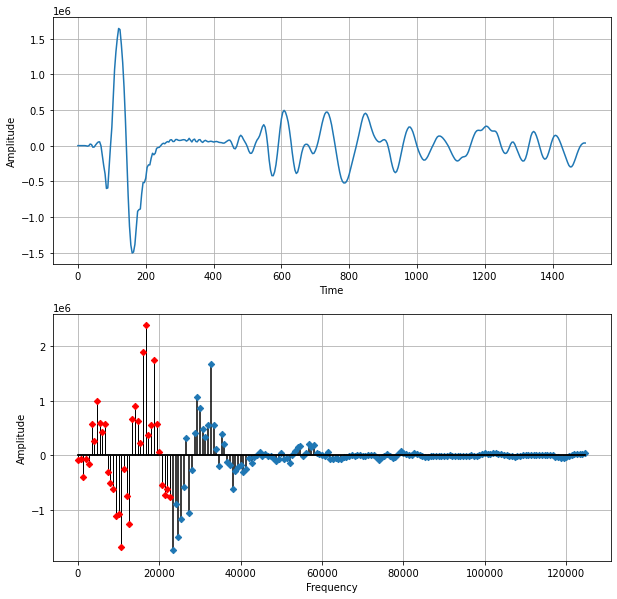

In [16]:
# 모든 id에 대해서, top 30에 들어가는 주파수들의 집합을 확인 해보면...
# 375종류 중에서 가장 작은 80가지라는 걸 알 수 있다
# 여기서 80번째 까지만, 남기면...
w0 = fourier_trsf(data=train_features,sensor='S2',idx=10,cutoff=30)

fig = plt.figure(figsize=(10,10))
ax1 = fig.add_subplot(2, 1, 1)
ax2 = fig.add_subplot(2, 1, 2)

ax1.plot(w0['time']*10**6, w0['wave'])
ax1.set_xlabel('Time')
ax1.set_ylabel('Amplitude')
ax1.grid(True)

tot_freq = w0['fft'][:int(375/2)+1]
keep_freq = tot_freq.copy()
keep_freq[35:] = np.nan
drop_freq = tot_freq.copy()
drop_freq[:35] = np.nan

markerline1, stemlines, baseline = ax2.stem(
    w0['freq'][:int(375/2)+1], drop_freq,
    linefmt='k-', markerfmt='D ', basefmt='k-'
    ) 
markerline2, stemlines, _ = ax2.stem(
    w0['freq'][:int(375/2)+1], keep_freq,
    linefmt='k-', markerfmt='rD ', basefmt='k-'
    ) 
ax2.set_xlabel('Frequency')
ax2.set_ylabel('Amplitude')
ax2.grid(True)

plt.setp(stemlines, linewidth = 1)
plt.setp(markerline1, markersize = 4.5)
plt.setp(markerline2, markersize = 4.5)

plt.show()

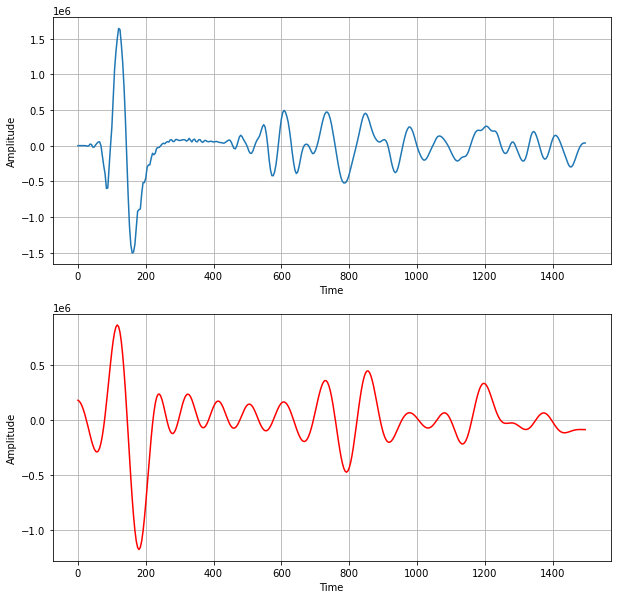

In [17]:
# 이렇게 근사시킨 형태의 파장을 얻을 수 있다
# 꽤 유사한 형태를 유지하고 있지만, 375개의 정보가 80개로 줄어들었다!
w0 = fourier_trsf(data=train_features,sensor='S2',idx=10,cutoff=35)

fig = plt.figure(figsize=(10,10))
ax1 = fig.add_subplot(2, 1, 1)
ax2 = fig.add_subplot(2, 1, 2)

ax1.plot(w0['time']*10**6, w0['wave'])
ax1.set_xlabel('Time')
ax1.set_ylabel('Amplitude')
ax1.grid(True)

ax2.plot(w0['time']*10**6, w0['fft_cutoff'], 'r') 
ax2.set_xlabel('Time')
ax2.set_ylabel('Amplitude')
ax2.grid(True)

plt.show()

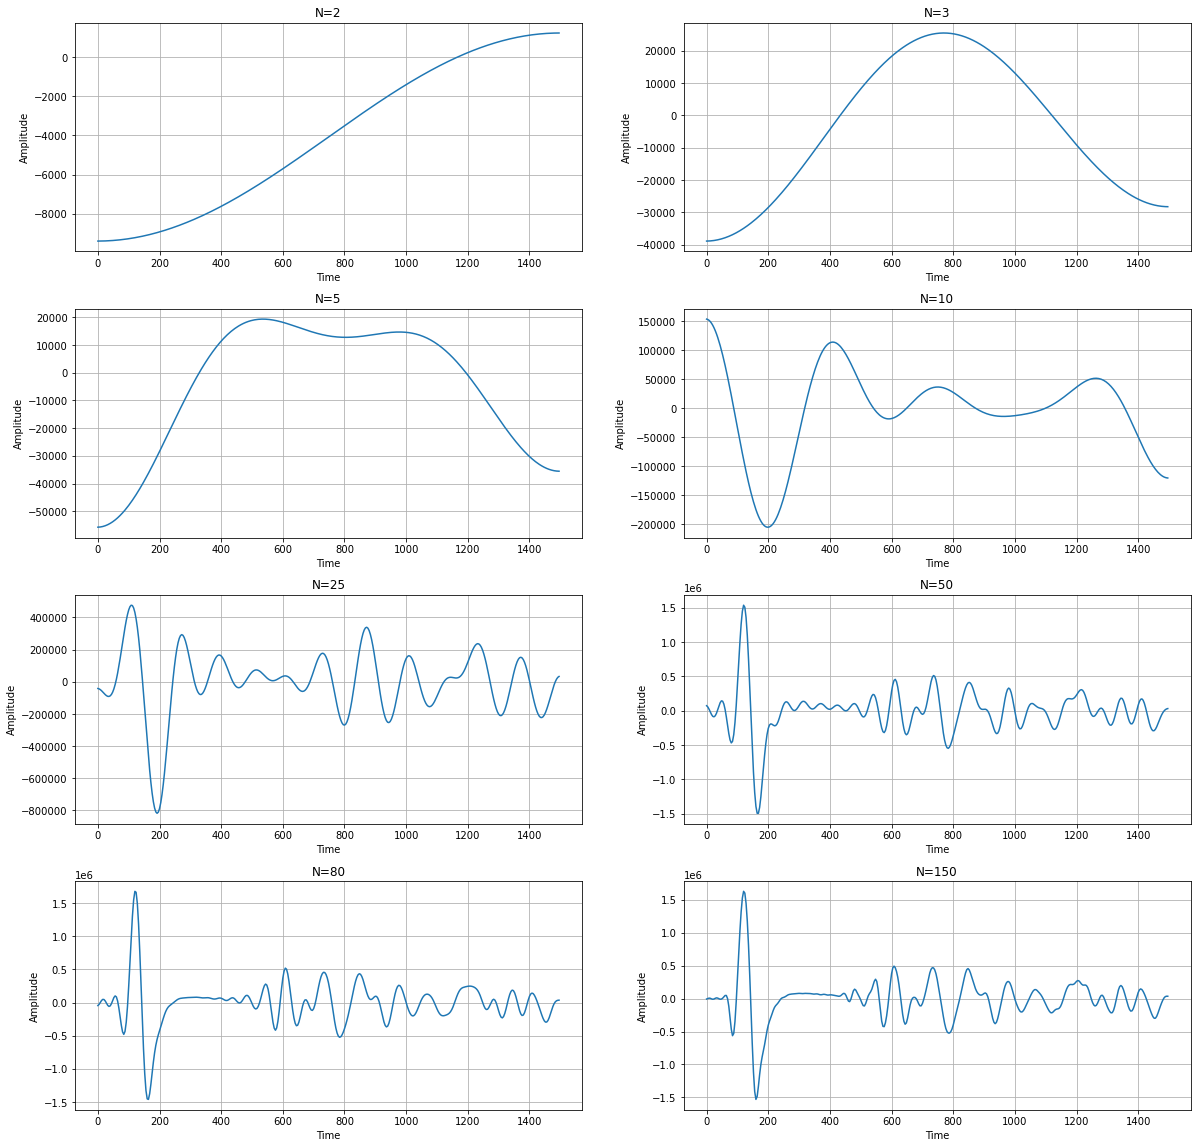

In [18]:
# fft의 원리를 간단히 보여주기

fig = plt.figure(figsize=(20,20))
gs = fig.add_gridspec(4, 2, hspace=0.25, wspace=0.2)
ax = gs.subplots()

select_id = 10
select_sensor = 'S2'

for r,nn in enumerate([2,3,5,10,25,50,80,150]):
    ww = fourier_trsf(data=train_features,sensor=select_sensor,idx=select_id,cutoff=nn)
    ax[r//2][r%2].plot(ww['time']*10**6, ww['fft_cutoff'])
    ax[r//2][r%2].set_xlabel('Time')
    ax[r//2][r%2].set_ylabel('Amplitude')
    ax[r//2][r%2].grid(True)
    ax[r//2][r%2].set_title('N='+str(nn))

plt.show()

In [19]:
# 혹시 train_target들 id 순서로 찍어보면 시계열 처럼 보일까? --> 다행히 아님
# 미리 세트를 세가지로 나누자 0.2 대 0.8로 나눠서 테스트, 훈련및 검증
# 훈련 및 검증을 0.2 대 0.8로 나눠서 검증, 훈련

<AxesSubplot:xlabel='id', ylabel='X'>

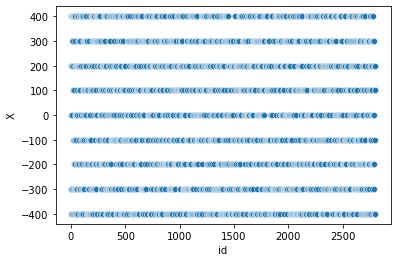

In [20]:
sns.scatterplot(x=train_target['id'],y=train_target['X'])

<AxesSubplot:xlabel='id', ylabel='Y'>

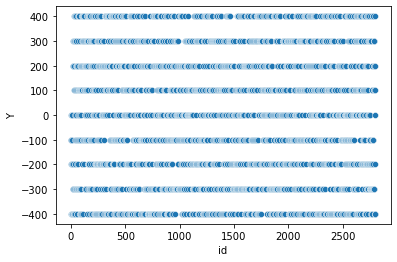

In [21]:
sns.scatterplot(x=train_target['id'],y=train_target['Y'])

<AxesSubplot:xlabel='id', ylabel='M'>

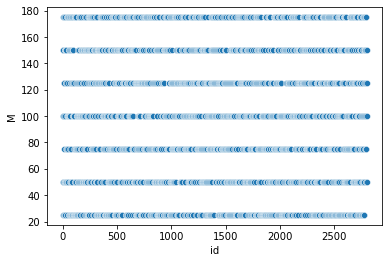

In [22]:
sns.scatterplot(x=train_target['id'],y=train_target['M'])

<AxesSubplot:xlabel='id', ylabel='V'>

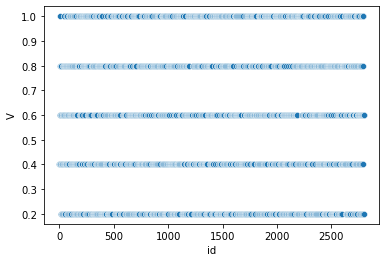

In [23]:
sns.scatterplot(x=train_target['id'],y=train_target['V'])